In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from imblearn.metrics import geometric_mean_score, classification_report_imbalanced
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import time

In [2]:
def plot_decision_function(X, y, clf, ax):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step), 
                         np.arange(y_min, y_max, plot_step))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor='k')

In [3]:
data = pd.read_csv('F:\Kuliah\Semester 7\Data Mining\Data Dow Jones\creditcard.csv', sep=',')
#data diambil dari kaggle.com/mlg-ulb/creditcardfraud

print (data.columns)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


In [4]:
data.shape

(284807, 31)

In [5]:
#print rangkuman statistik per feature
pd.options.display.float_format = "{:.6f}".format
data.describe(include='all')

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,...,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000
mean,94813.859575,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,...,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,88.349619,0.001727
std,47488.145955,1.958696,1.651309,1.516255,1.415869,1.380247,1.332271,1.237094,1.194353,1.098632,...,0.734524,0.725702,0.624460,0.605647,0.521278,0.482227,0.403632,0.330083,250.120109,0.041527
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,0.000000
25%,54201.500000,-0.920373,-0.598550,-0.890365,-0.848640,-0.691597,-0.768296,-0.554076,-0.208630,-0.643098,...,-0.228395,-0.542350,-0.161846,-0.354586,-0.317145,-0.326984,-0.070840,-0.052960,5.600000,0.000000
50%,84692.000000,0.018109,0.065486,0.179846,-0.019847,-0.054336,-0.274187,0.040103,0.022358,-0.051429,...,-0.029450,0.006782,-0.011193,0.040976,0.016594,-0.052139,0.001342,0.011244,22.000000,0.000000
75%,139320.500000,1.315642,0.803724,1.027196,0.743341,0.611926,0.398565,0.570436,0.327346,0.597139,...,0.186377,0.528554,0.147642,0.439527,0.350716,0.240952,0.091045,0.078280,77.165000,0.000000
max,172792.000000,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,...,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000,1.000000


In [6]:
print('No Frauds', round(data['Class'].value_counts()[0]/len(data) * 100,2), '% of the dataset')
print('Frauds', round(data['Class'].value_counts()[1]/len(data) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

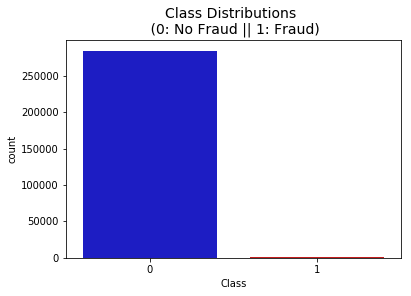

In [7]:
colors = ["#0101DF", "#DF0101"]

sns.countplot('Class', data=data, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

In [8]:
data.groupby('Class').size()

Class
0    284315
1       492
dtype: int64

In [9]:
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler menghilangkan median dan men-scale data berdasarkan quartile range-nya
# StandardScaler menghilangkan mean dan men-scale data ke unit variance

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

data['scaled_amount'] = std_scaler.fit_transform(data['Amount'].values.reshape(-1,1))
#data['scaled_time'] = rob_scaler.fit_transform(data['Time'].values.reshape(-1,1))

data.drop(['Time','Amount'], axis=1, inplace=True)

#mengubah nama kolom Time Amount menjadi scaled_time dan scaled_amount
scaled_amount = data['scaled_amount']
#scaled_time = data['scaled_time']

data.drop(['scaled_amount'], axis=1, inplace=True)
data.insert(0, 'scaled_amount', scaled_amount)
#data.insert(1, 'scaled_time', scaled_time)

data.head()

,scaled_amount,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,0.244964,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.342475,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,1.160686,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,0.140534,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,-0.073403,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


In [10]:
fraud_data_all = data.loc[data['Class'] == 1]
nonFraud_data_all = data.loc[data['Class']==0]

#menggabungkan data fraud dan non-fraud
normal_distributed_data_all = pd.concat([fraud_data_all, nonFraud_data_all])
normal_distributed_data_all.shape
#normal_distributed_data_all.head()
# data2.head()
#fraud_data_all.shape

X = normal_distributed_data_all.drop('Class', axis=1)
y = normal_distributed_data_all['Class']
#X2 --> variabel label untuk prediksi
#y2 --> variabel feature, semua kolom kecuali X (Class)
#Memecah dataframe baru menjadi training dan test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)
print ("Rincian class pada data training {} dan testing {} " .format(Counter(y_train), Counter(y_test)))

Rincian class pada data training Counter({0: 199013, 1: 351}) dan testing Counter({0: 85302, 1: 141}) 


In [11]:
t0 = time.time()
svm = SVC(gamma='auto', kernel='rbf', C=10)
svm.fit(X_train,y_train)
t1 = time.time()
print ("waktu training: {:3f} " .format(t1-t0))
X_train.shape

waktu training: 124.775587 


(199364, 29)

In [12]:
from sklearn.metrics import confusion_matrix
t2 = time.time()
y_pred = svm.predict(X_train)
conf_matrix_train = confusion_matrix(y_train, y_pred)
print (conf_matrix_train)
# print (X.shape)
print ("Classification Report:", '\n', classification_report_imbalanced(y_train, y_pred))
t3 = time.time()
print ("waktu predict training set: {:3f} " .format(t3-t2))

[[199011      2]
 [    34    317]]
Classification Report: 
                    pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      0.90      1.00      0.95      0.91    199013
          1       0.99      0.90      1.00      0.95      0.95      0.89       351

avg / total       1.00      1.00      0.90      1.00      0.95      0.91    199364

waktu predict training set: 26.170285 


In [13]:
t4= time.time()
y_pred_test = svm.predict(X_test)
# print(X_test.shape)
conf_matrix_test = confusion_matrix(y_test, y_pred_test)
print ("Confusion matrix:", '\n' ,conf_matrix_test)
# print (X_test.dtype)
print ("Classification Report:", '\n', classification_report_imbalanced(y_train, y_pred))
t5 = time.time()
print ("waktu predict testing set: {:3f} " .format(t5-t4))


Confusion matrix: 
 [[85298     4]
 [   37   104]]
Classification Report: 
                    pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      0.90      1.00      0.95      0.91    199013
          1       0.99      0.90      1.00      0.95      0.95      0.89       351

avg / total       1.00      1.00      0.90      1.00      0.95      0.91    199364

waktu predict testing set: 11.430513 


In [14]:
svm

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [15]:
# from sklearn.decomposition import PCA

# fig, ax = plt.subplots(1,figsize=(8,5))

# pca = PCA(n_components=2)
# Xreduced = pca.fit_transform(X_train)

# classifier = svm.fit(Xreduced, y_train)
# plot_decision_function(Xreduced,y_train, classifier, ax)
# fig.tight_layout()

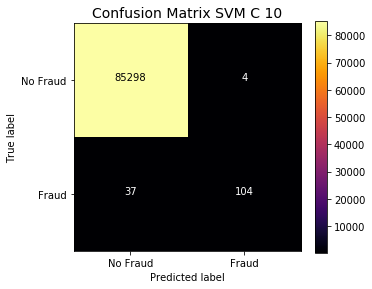

In [17]:
from sklearn.metrics import confusion_matrix

#Menerapkan confusion matrix pada testing set
y_pred = svm.predict(X_test)


#log
#mengganti testing setnya dengan testing set untuk data keseluruhan
svm_cf = confusion_matrix(y_test, y_pred)

import itertools

# Create a confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "white")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
labels = ['No Fraud', 'Fraud']

fig = plt.figure(figsize=(5,4))

plot_confusion_matrix(svm_cf, labels, title="Confusion Matrix SVM C 10", cmap=plt.cm.inferno)